### Bonus assignment Math 164 Fall 2024 ###
Shilpa Bojjireddy

In [1]:
# required packages

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from scipy.sparse.linalg import lsqr, eigsh, aslinearoperator, svds, cg, LinearOperator, spsolve
from scipy import ndimage, sparse
from scipy.sparse.linalg import inv as sparse_inv
import scipy.sparse.linalg as spla



In [3]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

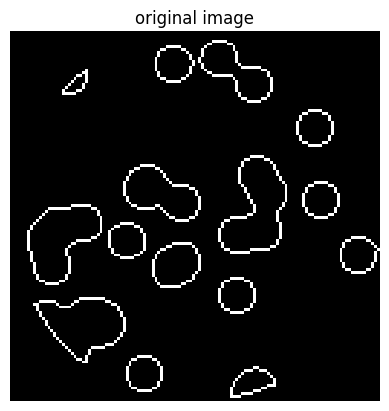

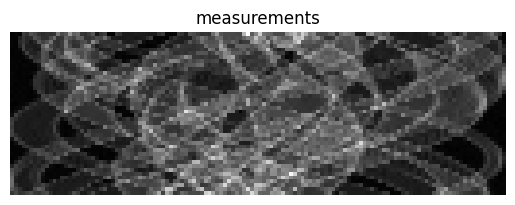

In [ ]:
# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 3)
data = generate_synthetic_data()
# Projection operator A, is applied to the synthetic data
proj = proj_operator @ data.ravel()[:, np.newaxis]
# adds random noise- produces sinogram forward model
proj += 0.15 * np.random.randn(*proj.shape)


plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.show()


plt.imshow(proj.reshape(-1,l), cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("measurements")
plt.show()

## 1. Difficulties of inverse problems ##

####(1)
Difficulties of inverse problems. Our goal here is to understand why it will be tricky to reconstruct an image from data. For that, we will consider the role of the number of measurement directions n and the noise η:
___
####(a)
If $n = l$ and the matrix $A$ were invertible, we could consider $\hat{\mathbf{x}} = A^{-1} \mathbf{y}_\eta$ as an estimate for the reconstruction. However, in practice, folks take (for various reasons) $n < l$ directions into account. Compute and plot the eigenvalues of $A^\top A$ for $n \in \{ l/8, l/4, l/2, l \}$ and describe what you see.

**Observations**

Effects of Increasing n:
- n represents the number of projection directions used to generate the sinogram
- As n increases:
  - Larger Eigenvalues: increase, implying that more projection angles improve the matrix's ability to capture important parts of the image.
    so the reconstruction will be more stable
___
####(b)
Instead of using the inverse of $A$, consider the **pseudo-inverse** given by:

$$
A^\dagger := A^\top (AA^\top)^{-1}.
$$

Compute and plot the reconstruction $A^\dagger \mathbf{y}_\eta \in \mathbb{R}^{l^2}$ as an $l \times l$ image for data generated with noise $\eta \sim \mathcal{N}(0, \sigma^2 I_n)$ for $\sigma \in \{0, 0.05, 0.1, 0.15\}$ and describe what you see.

**Solution**: As the noise level increases, the reconstructed image exhibits a higher degree of smoothing and loss of detail, resulting in reduced sharpness and clarity.

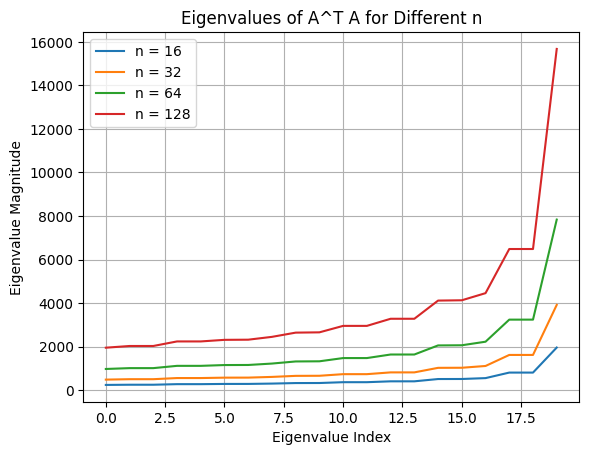

In [6]:
# 1a

# Compute and plot eigenvalues of A^TA for n = {l/8, l/4, l/2, l}
# Function to compute and plot eigenvalues for A^T A

l = 128 # image size
n_values = [l//8, l//4, l//2, l] # Number of projection directions
def compute_and_plot_eigenvalues(l, n_values):
  for n_dir in n_values:
    proj_operator = build_projection_operator(l, n_dir)

    # compute A^TA
    A = proj_operator
    AtA = A.T @ A # sparse matrix generated
    k = min(20, AtA.shape[0] // 2)  # Number of eigenvalues to compute
    eigenvals = eigsh(AtA, k=k, which='LM', return_eigenvectors=False)
    plt.plot((eigenvals), label=f"n = {n_dir}")

  plt.xlabel("Eigenvalue Index")
  plt.ylabel("Eigenvalue Magnitude")
  plt.title("Eigenvalues of A^T A for Different n")
  plt.legend()
  plt.grid()
  plt.show()

compute_and_plot_eigenvalues(l, n_values)

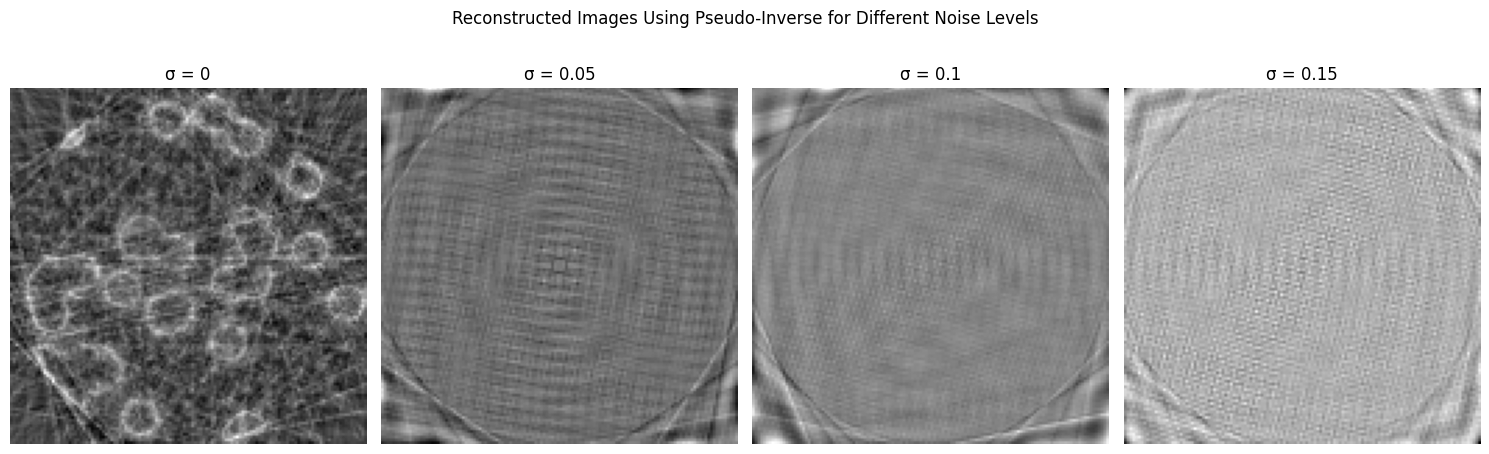

In [7]:
# 1b

# Parameters
l = 128
n = l // 8
sigma_values = [0, 0.05, 0.1, 0.15]  # Different noise levels

# Generate synthetic data and projection operator
data = generate_synthetic_data()
proj_operator = build_projection_operator(l, n)
# data_flat = data.ravel()
data_flat = data.ravel()[:, np.newaxis]
# Project the data to obtain vectorized sinogram image (without noise)
proj = proj_operator @ data_flat


fig, axes = plt.subplots(1, len(sigma_values), figsize=(15, 5))

for i, sigma in enumerate(sigma_values):

    # Add noise to the projection
    y_noisy = proj + sigma * np.random.normal(0, 1, proj.shape)

    # Compute pseudo-inverse A† = A⊤(AA⊤)⁻¹ using a linear system solver (conjugate gradient)
    ATA = proj_operator @ proj_operator.T  # A A⊤
    pseudo_inverse = proj_operator.T @ cg(ATA, y_noisy)[0]  # A⊤(AA⊤)⁻¹ y

    # Reconstruct the image
    reconstructed = pseudo_inverse.reshape((l, l))

    # Plot the reconstructed image
    ax = axes[i]
    ax.imshow(reconstructed, cmap="gray")
    ax.set_title(f"σ = {sigma}")
    ax.axis("off")

plt.suptitle("Reconstructed Images Using Pseudo-Inverse for Different Noise Levels")
plt.tight_layout()
plt.show()


## 2. Variational reconstruction ##

####(2a)
In practice, $l$ might be very large. So large that even storing the matrix $A$ is not feasible. So explicitly solving a linear system as done in 1b will not be the way to go (apart from its current issues). Instead, we will try to solve adaptations of the minimization problem:

$$
\min_{\mathbf{x} \in \mathbb{R}^l} \| A\mathbf{x} - \mathbf{y}_\eta \|^2. \tag{3}
$$

Show that $$ A^\dagger \mathbf{y}_\eta $$ solves the least squares problem \(3\). It suffices to check first-order necessary conditions.

To solve:

$$
\min_{\mathbf{x} \in \mathbb{R}} \| A\mathbf{x} - \mathbf{y}_n \|^2
$$

**Solution**:

Let $$ \mathbf{x}^* = A^\dagger \mathbf{y}_n = A^T (AA^T)^{-1} \mathbf{y}_n $$.

For any $\mathbf{d}$, we have:

$$
\mathbf{d}^T \nabla f(\mathbf{x}^*) \geq 0
$$

Define $f(\mathbf{x}) = \| A\mathbf{x} - \mathbf{y}_n \|^2 $:

$$
f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^T (2A^T A) \mathbf{x} - \mathbf{x}^T (2A^T \mathbf{y}_n) + \mathbf{y}_n^T \mathbf{y}_n
$$

Gradient of $ f(\mathbf{x}) $:

$$
\nabla f(\mathbf{x}) = 2A^T A \mathbf{x} - 2A^T \mathbf{y}_n
$$

Setting $ \nabla f(\mathbf{x}) = 0 $:

$$
A^T A \mathbf{x} = A^T \mathbf{y}_n
$$

Therefore:

$$
\mathbf{x}^* = (A^T A)^{-1} A^T \mathbf{y}_n = A^\dagger \mathbf{y}_n
$$



####(2b)

From 1 we know that solving (3) will not go down great. Instead, we will add **regularization**. That is, we propose to solve the minimization problem:

$$
\min_{\mathbf{x} \in \mathbb{R}^l} \| A\mathbf{x} - \mathbf{y}_\eta \|^2 + \lambda \| \mathbf{x} \|^2,
\tag{4}
$$

where $ \lambda > 0 $.

If the first term in (4) encodes the information that $ \mathbf{x} $ should fit the data, what does the second term — the regularization term — encode?

**Solution:**
*   The regularization term ensures that x doesn't become overly complex or large.
* It minimizes $||x||^2$, so it penalizes large values of $x$, effectively controlling the complexity of the solution.
* By discouraging overly large components of $x$, it helps in stabilizing the solution, especially when the data is very noisy.
* A larger $\lambda$ increases the penalty on $x$, generalizing the solution better.
* A smaller $\lambda$ reduces the regularization effect, and allows the model to fit the data more closely. But beware of overfitting.



#### (2c)
The first-order optimality conditions for (4) are again a linear system. Write down this system of equations in matrix notation.
$$(Ax - y_n)^T(Ax - y_n) + \lambda x^T x $$
**Solution**
$$\begin{aligned}
&= A^T x^T A x - y_n^T A x - A x^T y_n + y_n^T y_n + \lambda x^T x \\
&= \frac{1}{2} x^T(2 A^T A) x - \lambda x^T (2 A^T y_n) + y_n^T y_n + \lambda x^T x \\
\nabla f(x) &= (2 A^T A) x - 2 A^T y_n + 2 \lambda x = 0 \\
&= (A^T A + \lambda I) x = A^T y_n
\end{aligned}$$


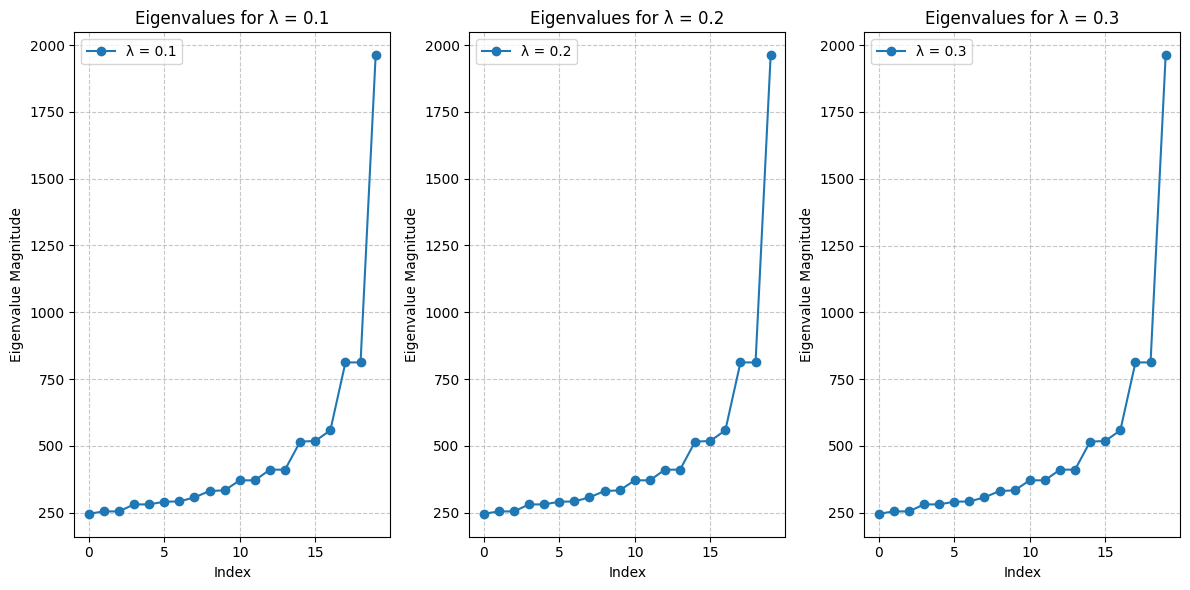

In [8]:
# 2d
# Plotting eigenvalues of matrix in part 2c

# Parameters
l = 128
n = l // 8
noise_level = 0.15
lambdas = [0.1, 0.2, 0.3]

# Compute A, Ax
proj_operator = build_projection_operator(l, n)

# Compute A^T A
ATA = proj_operator.T @ proj_operator
plt.figure(figsize=(12, 6))

for i, lambda_val in enumerate(lambdas,1):
    # Compute (A^T A + λI)
    regularized_matrix = ATA + lambda_val * np.eye(ATA.shape[0])

    # Compute top k eigenvalues iteratively
    k = min(20, regularized_matrix.shape[0] // 2)
    eigenvalues, _ = spla.eigsh(regularized_matrix, k=k, which='LM') # Largest eigenvalues

    plt.subplot(1, 3, i)
    plt.plot((eigenvalues), marker='o', linestyle='-', label=f'λ = {lambda_val}')
    plt.title(f'Eigenvalues for λ = {lambda_val}')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

plt.tight_layout()
plt.show()




## 3. Optimization ##

### 3. Optimization

Our goal here is to see the effect of the parameter $\lambda$ on the performance of optimization algorithms. For this, we will implement two methods we have learned in the course:

---

#### (a)

Implement gradient descent with fixed step size from $\mathbf{x}^0 = 0 \in \mathbb{R}^{l^2}$ for the same settings as in 2d. Report explicitly how you picked the step size (*Hint*: the eigenvalues computed in 1d will come in helpful) and stopping criterion, and plot the progression of the losses

$$
= \| A\mathbf{x}^k - \mathbf{y}_\eta \|^2 + \lambda \| \mathbf{x}^k \|^2
$$

for all three $\lambda$ in one plot. Describe what you see.

**Solution**

The fixed step size was determined based on the Lipschitz constant and the maximum eigenvalue identified in 1d. Using this step size, the loss progression converges for all values of $\lambda$, with the losses being relatively similar in magnitude. However, when the step size was chosen using the theorem $\frac{2}{\max{{\lambda}}}$, the losses diverged.


---

#### (b)

Repeat 3a for conjugate gradient.

**Solution**

Observe that the image fits the data more closely with a smaller $\lambda$, showing what we described in question 2. Also, loss decreases faster as $\lambda$ decreases. This is because weaker regularization facilitates faster loss reduction but can lead to solutions that are sensitive to noise.

[1961.80906111]


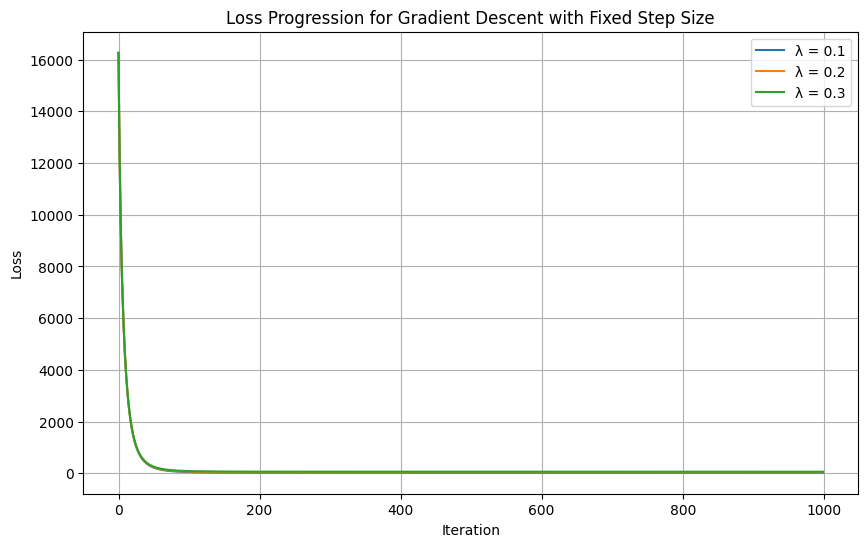

In [7]:
l = 128
n = l // 8
sigma = 0.15 # Noise
lambd_values = [0.1, 0.2, 0.3]
max_iter = 1000 # Maximum number of iterations

# Generate projection operator and synthetic data
data = generate_synthetic_data()
proj_operator = build_projection_operator(l, n)
data_flat = data.ravel()
proj = proj_operator @ data_flat  # y (measurements)
proj += sigma * np.random.randn(*proj.shape)  # Add noise (y_noisy)
A = proj_operator

# Calculate fixed step size based on largest eigenvalue of A^T A
ATA = A.T @ A
k = 1  # Number of eigenvalues to compute
largest_eigenvalue, _ = eigsh(ATA, k=k, which="LM")  # LM = Largest Magnitude
step_size = 1 / (2 * largest_eigenvalue)  # Fixed step size based on Lipschitz constant (using 2/maxeigenval -> diverge)
print(largest_eigenvalue)

# Implement gradient descent for each lambda
losses = []
for lambd in lambd_values:
    x = np.zeros(A.shape[1])  # Initial guess
    loss_history = []

    for iteration in range(max_iter):
        # Compute gradient
        grad = 2 * A.T @ (A @ x - proj) + 2 * lambd * x

        # Update x with fixed step size
        x -= step_size * grad

        # Compute loss
        loss = np.linalg.norm(A @ x - proj) ** 2 + lambd * np.linalg.norm(x) ** 2
        loss_history.append(loss)

    losses.append(loss_history)

# Plot the loss progression for all three lambdas
plt.figure(figsize=(10, 6))
for i, loss_history in enumerate(losses):
    plt.plot(loss_history, label=f"λ = {lambd_values[i]}")
plt.title("Loss Progression for Gradient Descent with Fixed Step Size")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


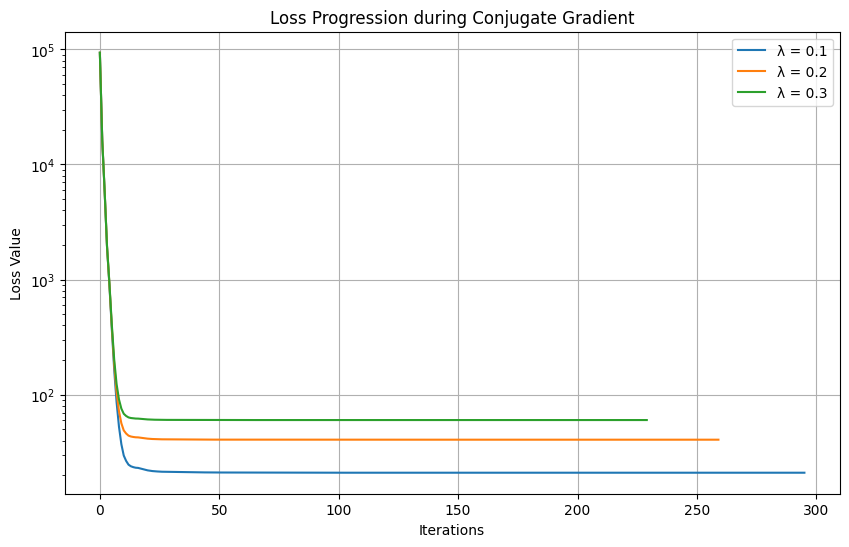

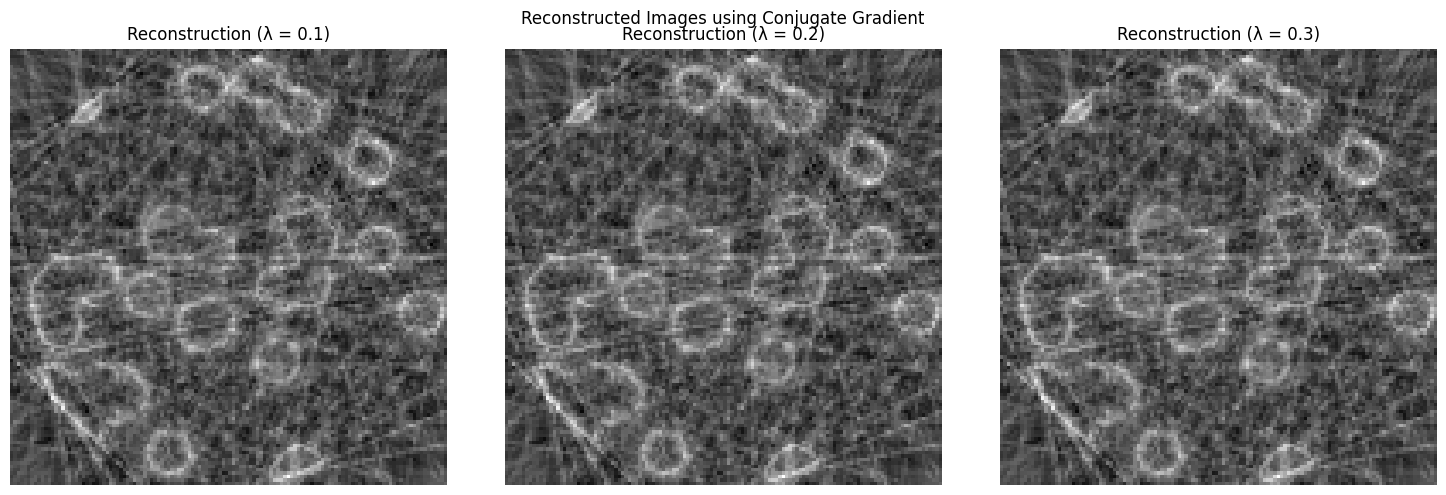


λ = 0.1
Final Loss: 21.008152071306082
Iterations to converge: 296

λ = 0.2
Final Loss: 40.676599204266246
Iterations to converge: 260

λ = 0.3
Final Loss: 60.249858025725004
Iterations to converge: 230


In [ ]:
# Parameters:
l = 128
n = l // 8
sigma = 0.15
lambdas = [0.1, 0.2, 0.3]

data = generate_synthetic_data()
proj_operator = build_projection_operator(l, n)
data_flat = data.ravel()[:, np.newaxis]
proj = proj_operator @ data_flat
proj += sigma * np.random.randn(*proj.shape)

def conjugate_gradient(A, b, lambda_val, max_iter=1000, tol=1e-6):
    """
    Conjugate Gradient method with regularization

    Parameters:
    A (numpy.ndarray): Projection operator
    b (numpy.ndarray): Projection data
    lambda_val (float): Regularization parameter
    max_iter (int): Maximum iterations
    tol (float): Convergence tolerance

    Returns:
    tuple: (solution, loss history)
    """
    # Regularized operator A^T A + λI
    ATA = A.T @ A
    regularized_op = lambda x: ATA @ x + lambda_val * x

    # Right-hand side
    rhs = A.T @ b

    # Initial guess
    x = np.zeros_like(rhs)

    # Initialization
    r = rhs - regularized_op(x)
    p = r.copy()

    loss_history = []

    for k in range(max_iter):
        # Compute loss
        loss = np.linalg.norm(A @ x - b)**2 + lambda_val * np.linalg.norm(x)**2
        loss_history.append(loss)

        # Check convergence
        if np.linalg.norm(r) < tol:
            break

        # CG update steps
        Ap = regularized_op(p)
        alpha = np.dot(r.T, r) / np.dot(p.T, Ap)
        x += alpha * p
        r_new = r - alpha * Ap

        # Beta for next iteration
        beta = np.dot(r_new.T, r_new) / np.dot(r.T, r)

        # Update for next iteration
        p = r_new + beta * p
        r = r_new

    return x, loss_history

# Conjugate Gradient Analysis
plt.figure(figsize=(10, 6))

for lambda_val in lambdas:
    # Perform Conjugate Gradient
    x_cg, loss_history = conjugate_gradient(proj_operator, proj, lambda_val)

    # Plot loss progression
    plt.plot(loss_history, label=f'λ = {lambda_val}')

plt.title('Loss Progression during Conjugate Gradient')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Reconstruct and visualize images
plt.figure(figsize=(15, 5))

for i, lambda_val in enumerate(lambdas):
    # Perform Conjugate Gradient
    x_cg, _ = conjugate_gradient(proj_operator, proj, lambda_val)

    # Reshape to image
    reconstructed_image = x_cg.reshape((l, l))

    # Plot reconstructed image
    plt.subplot(1, 3, i+1)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'Reconstruction (λ = {lambda_val})')
    plt.axis('off')

plt.suptitle('Reconstructed Images using Conjugate Gradient')
plt.tight_layout()
plt.show()

for lambda_val in lambdas:
    x_cg, loss_history = conjugate_gradient(proj_operator, proj, lambda_val)
    print(f"\nλ = {lambda_val}")
    print(f"Final Loss: {loss_history[-1]}")
    print(f"Iterations to converge: {len(loss_history)}")


## 4. Model refinement ##

### 4. Model refinement

Our goal here is to revisit our modeling assumption that led to (4) and try something better, but more tricky to optimize. For that, we will try a different regularizer:

---

#### (a)

We know that the reconstruction we try to find is **sparse**, i.e., most pixels have value 0. The $\ell^2$-regularizer in (4) does not really encode this. There is a better choice to enforce these types of solutions: $\ell^1$-regularization. That is, we now aim to solve the minimization problem:

$$
\min_{\mathbf{x} \in \mathbb{R}^{l^2}} \| A\mathbf{x} - \mathbf{y}_\eta \|^2 + \lambda \sum_{i=1}^{l^2} |\mathbf{x}_i|. \tag{5}
$$

The absolute value is not differentiable at 0. This could lead to trouble (but it is worth it!). To see some potential issues, minimize the 1D problem $f(t) = |t|$ using gradient descent with a fixed step size of 1 from $t^0 = \frac{13}{4}$. Plot the progression of the loss $= |t^k|$ and explain the behavior you see.

**Solution**

The Progression of losses starts to oscillate, then diverging when we use a fixed step size. One possible explanation is that since the $l1$ regularizer is non-differentiable (even though only at $t = 0$), updates may overshoot near $t=0$ causing oscillatory behavior.\

---

#### (b)

Since the $\ell^1$ regularizer is non-differentiable (even though only at $t = 0$), the theory from class does not hold. We will try making some modifications to gradient descent. Try again to minimize the 1D function in 4a, but now with an adaptive step size $\alpha_k = \frac{1}{k+1}$. Again, plot the progression of the loss $= |t^k|$.

**Solution**

With an adaptive stepsize, we converge!

---

#### (c)

Finally, solve (5) with $\lambda = 0.001$ using gradient descent with an adaptive step size similar to 4b (but potentially a different constant than 1 in the numerator) and $\mathbf{x}^0 = 0 \in \mathbb{R}^{l^2}$. (*Hint*: the choice for step size in 3b will come in helpful). Report your stopping criterion, plot the progression of the loss, and plot the image. Compare the reconstruction to those from 2b.

**Solution**

**Sharpness and Sparsity:**

- ℓ1-Regularization: Produces sharper images by enforcing sparsity but introduces blocky artifacts.

- ℓ2-Regularization: Produces smoother but blurrier reconstructions, lacking sharp features.

**Noise Handling:**

- ℓ1-Regularization: Suppresses high-frequency noise effectively but retains structured artifacts.

- ℓ2-Regularization: Diffuses noise, leading to progressively blurrier reconstructions as noise increases.

**Sparsity vs. Smoothness:**

- ℓ1-Regularization: Ideal for sharp, well-defined features (edges).

- ℓ2-Regularization: Better for smooth, continuous data but struggles with detail retention.







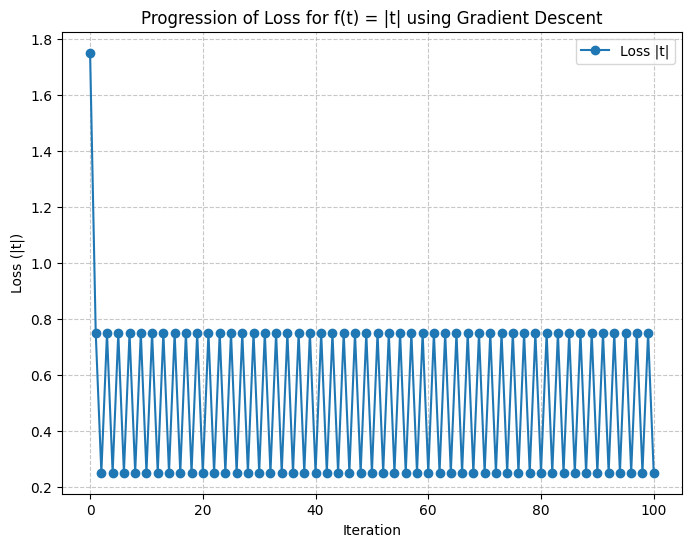

In [11]:
# 4a

# Define the 1D function f(t) = |t|
def f(t):
    return np.abs(t)

# Define the gradient of f(t) (subgradient)
def grad_f(t):
    if t > 0:
        return 1
    elif t < 0:
        return -1
    else:
        return 0  # Subgradient at t = 0

# Gradient descent for the 1D function
t0 = 1.75  # Initial value of t
step_size = 1  # Fixed step size
max_iter = 100  # Maximum number of iterations

t_values = [t0]
loss_values = [f(t0)]

t = t0
for k in range(max_iter):
    # Compute the gradient
    grad = grad_f(t)

    # Update t using gradient descent
    t -= step_size * grad

    # Store the current t and loss
    t_values.append(t)
    loss_values.append(f(t))

    # Stop if t converges to 0 (minimum of |t|)
    if t == 0:
        print(f"Converged at iteration {k}")
        break

# Plot the progression of the loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_values)), loss_values, marker='o', linestyle='-', label='Loss |t|')
plt.title("Progression of Loss for f(t) = |t| using Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("Loss (|t|)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


The Progression of losses starts to oscillate, then diverging when we use a fixed step size. One possible explanation is that since the $l1$ regularizer is non-differentiable (even though only at $t = 0$), updates may overshoot near $t=0$ causing oscillatory behavior.\

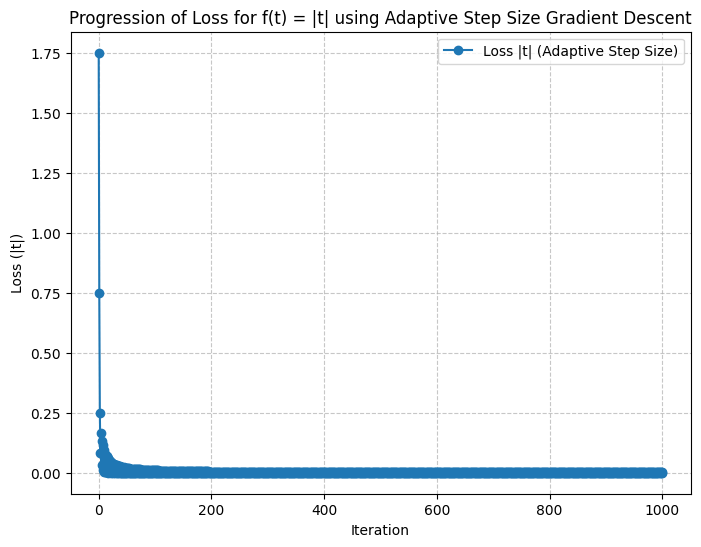

In [13]:
# 4b

# Gradient descent with adaptive step size α_k = 1 / (k + 1)
t0 = 1.75  # Initial value of t
max_iter = 1000  # Maximum number of iterations

t_values_adaptive = [t0]
loss_values_adaptive = [f(t0)]

t = t0
for k in range(max_iter):
    # Compute the adaptive step size
    step_size = 1 / (k + 1)

    # Compute the gradient
    grad = grad_f(t)

    # Update t using gradient descent with adaptive step size
    t -= step_size * grad

    # Store the current t and loss
    t_values_adaptive.append(t)
    loss_values_adaptive.append(f(t))

    # Stop if t converges to 0 (minimum of |t|)
    if t == 0:
        print(f"Converged at iteration {k}")
        break

plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_values_adaptive)), loss_values_adaptive, marker='o', linestyle='-', label='Loss |t| (Adaptive Step Size)')
plt.title("Progression of Loss for f(t) = |t| using Adaptive Step Size Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("Loss (|t|)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

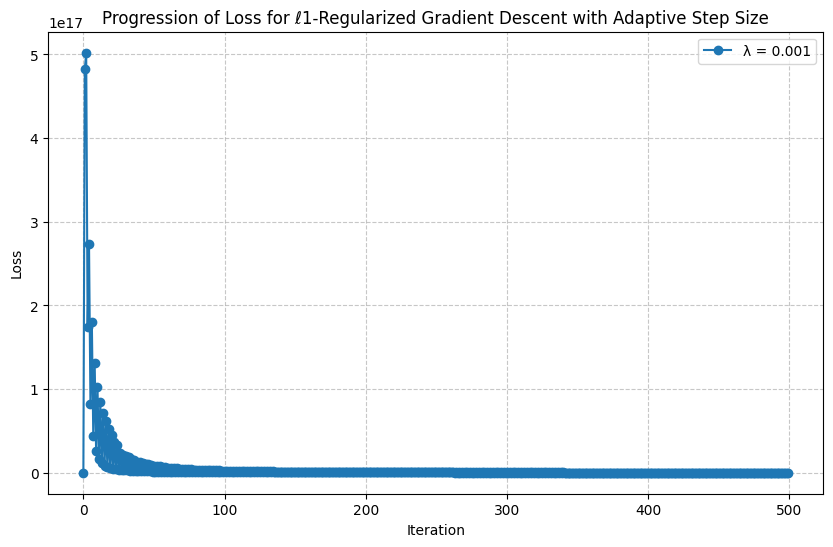

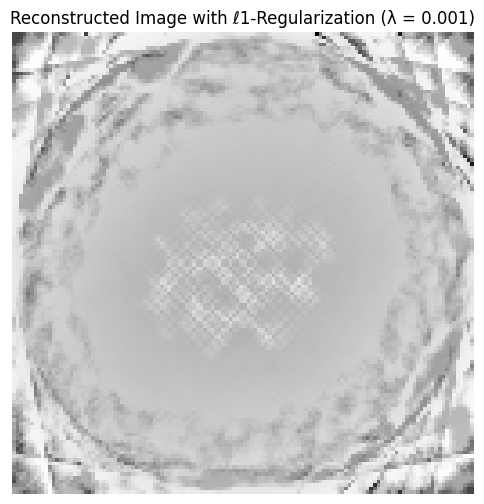

In [19]:
# 4c
# Parameters:
l = 128
n = l // 8
sigma = 0.15
lambda_val = 0.001  # Regularization parameter for ℓ1 regularization
max_iter = 500  # Maximum number of iterations
tolerance = 1e-6  # Tolerance for stopping criterion
step_size_const = 1  # Constant for adaptive step size

# Generate synthetic data and projection operator
data = generate_synthetic_data()
proj_operator = build_projection_operator(l, n)
data_flat = data.ravel()

# Project the data and add noise
proj = proj_operator @ data_flat  # y (measurements)
y_noisy = proj + sigma * np.random.randn(*proj.shape)

# Gradient Descent with ℓ1 regularization and adaptive step size
x = np.zeros_like(data_flat, dtype=float)  # Initial guess (x0 = 0)
loss_history = []

for k in range(1, max_iter + 1):
    # Compute the gradient (subgradient for |x|)
    grad = 2 * proj_operator.T @ (proj_operator @ x - y_noisy) + lambda_val * np.sign(x)

    # Clip gradients for numerical stability
    grad = np.clip(grad, -1e6, 1e6)

    # Adaptive step size
    step_size = step_size_const / (k + 1)

    # Update x
    x -= step_size * grad

    # Compute loss (ℓ1 regularized objective)
    loss = np.linalg.norm(proj_operator @ x - y_noisy) ** 2 + lambda_val * np.sum(np.abs(x))
    loss_history.append(loss)

    # if k % 50 == 0:
    #     print(f"Iteration {k}, Loss: {loss}")

    # Stopping criterion
    if k > 1 and abs(loss_history[-1] - loss_history[-2]) < tolerance:
        print(f"Converged at iteration {k}")
        break

plt.figure(figsize=(10, 6))
plt.plot(loss_history, marker='o', linestyle='-', label=f'λ = {lambda_val}')
plt.title("Progression of Loss for ℓ1-Regularized Gradient Descent with Adaptive Step Size")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Reshape and plot the reconstructed image
try:
    reconstructed_image = x.reshape((l, l))
    plt.figure(figsize=(6, 6))
    plt.imshow(reconstructed_image, cmap="gray")
    plt.title("Reconstructed Image with ℓ1-Regularization (λ = 0.001)")
    plt.axis("off")
    plt.show()
except ValueError as e:
    print(f"Error reshaping x: {e}")
